In [ ]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt



# 1. Data Preparation & Segmentation

In [14]:
# Load and sample data
X = pd.read_csv("Online Retail - Online Retail.csv" )

# Create 20% random sample
online = X 

# Create revenue column
online['Sales_Amount'] = online['Quantity'] * online['UnitPrice']

# Convert dates
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'], format='%m/%d/%y %H:%M')
# Truncate to month start
def get_month(x): 
    return dt.datetime(x.year, x.month, 1)
online['TransactionMonth'] = online['InvoiceDate'].apply(get_month)

# Find acquisition month for each customer
grouping = online.groupby('CustomerID')['TransactionMonth']
online['AcquisitionMonth'] = grouping.transform('min')

# 2. Time Offset Calculation (Cohort Index)

In [5]:
# Extract date parts for calculations
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get integer values for calculations
txn_year, txn_month, _ = get_date_int(online, 'TransactionMonth')
acq_year, acq_month, _ = get_date_int(online, 'AcquisitionMonth')

# Calculate life stage (months since acquisition)
online['cust_life_stage'] = (txn_year - acq_year) * 12 + (txn_month - acq_month) + 1

# 3. Cohort Table Creation

In [6]:
# Create pivot table for retention (unique customer counts)
grouping = online.groupby(['AcquisitionMonth', 'cust_life_stage'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='AcquisitionMonth', 
                                  columns='cust_life_stage', 
                                  values='CustomerID')

 # 4. Retention Rate Calculation

In [7]:
# Calculate retention percentage
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention_formatted = (retention.round(3) * 100).astype(str) + '%'

# 5. Value Analysis - Average Quantity

In [8]:
# Average quantity per cohort
grouping = online.groupby(['AcquisitionMonth', 'cust_life_stage'])
cohort_qty = grouping['Quantity'].mean().reset_index()
avg_quantity = cohort_qty.pivot(index='AcquisitionMonth', 
                                columns='cust_life_stage', 
                                values='Quantity')

# 6. Value Analysis - Revenue (using Median)

In [9]:
# Median revenue per cohort (median to avoid outlier distortion)
grouping = online.groupby(['AcquisitionMonth', 'cust_life_stage'])
cohort_rev = grouping['Sales_Amount'].median().reset_index()
avg_revenue = cohort_rev.pivot(index='AcquisitionMonth', 
                               columns='cust_life_stage', 
                               values='Sales_Amount')

# 7. Visualizations

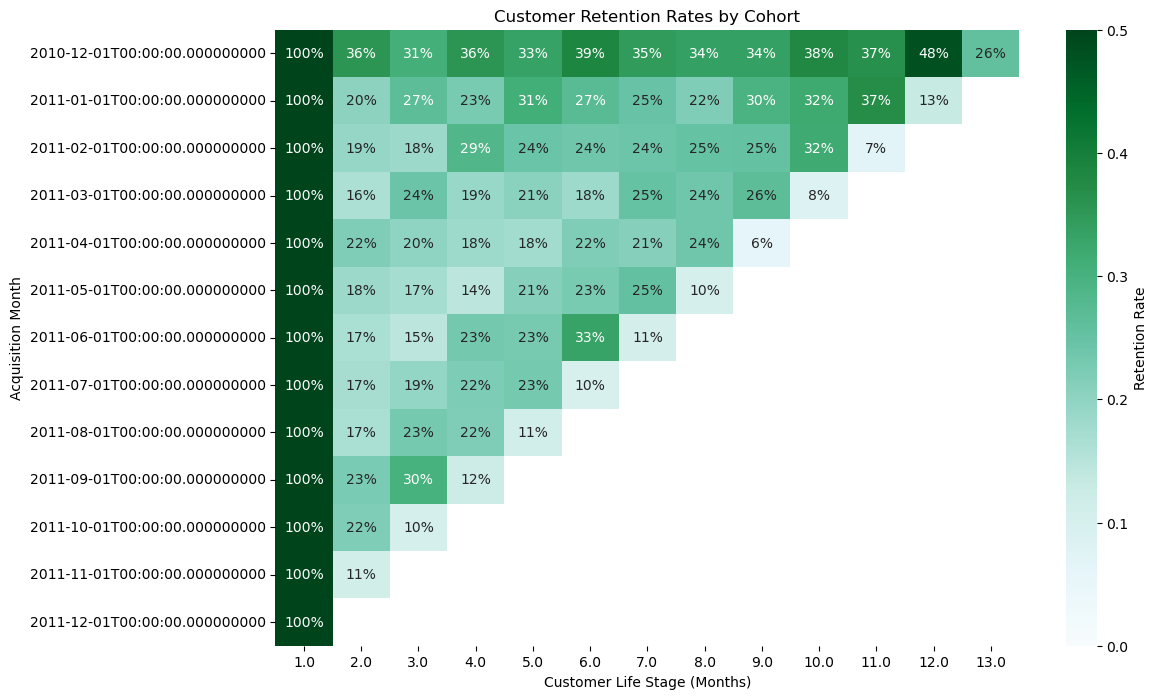

In [10]:
# A. Retention Heatmap:

plt.figure(figsize=(12, 8))
plt.title('Customer Retention Rates by Cohort')
sns.heatmap(data=retention, 
            annot=True, 
            fmt='.0%', 
            vmin=0.0, 
            vmax=0.5, 
            cmap='BuGn',
            cbar_kws={'label': 'Retention Rate'})
plt.ylabel('Acquisition Month')
plt.xlabel('Customer Life Stage (Months)')
plt.show()

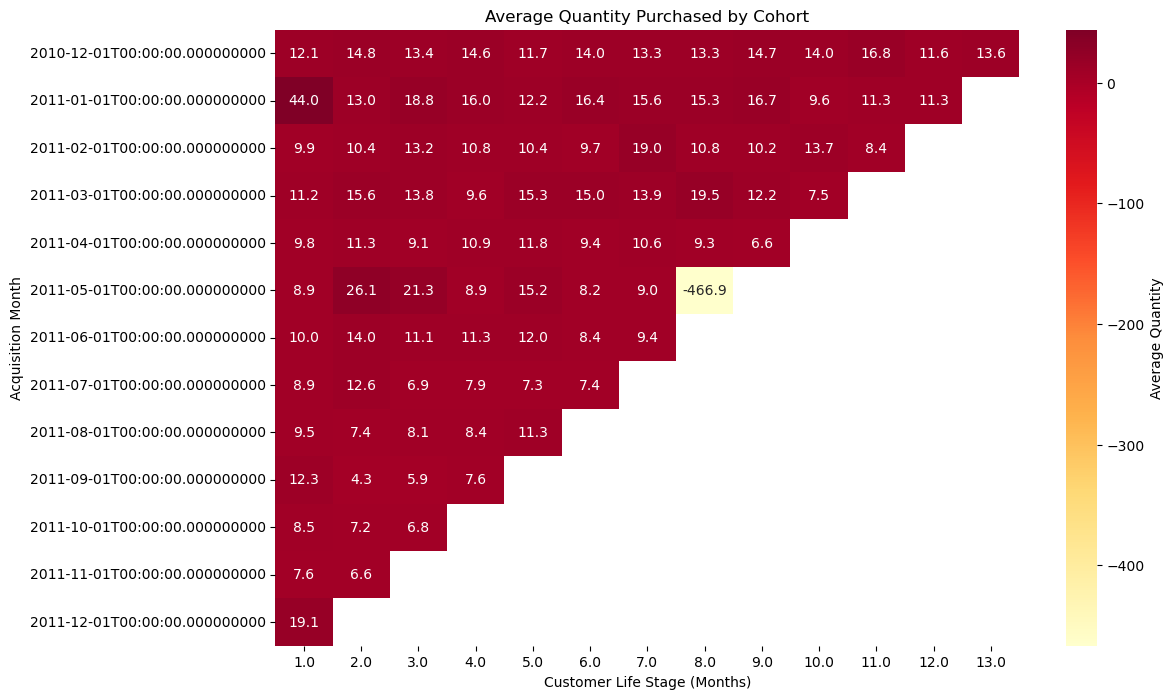

In [11]:
# B. Average Quantity Heatmap:

plt.figure(figsize=(12, 8))
plt.title('Average Quantity Purchased by Cohort')
sns.heatmap(data=avg_quantity, 
            annot=True, 
            fmt='.1f', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Average Quantity'})
plt.ylabel('Acquisition Month')
plt.xlabel('Customer Life Stage (Months)')
plt.show()

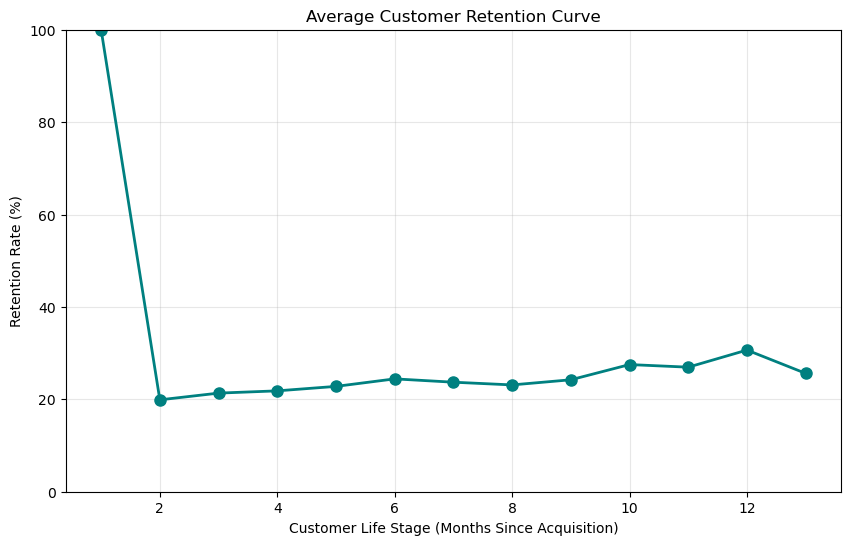

In [12]:
# C. Retention Curve (J-Curve):

# Calculate average retention across all cohorts
retention_curve = retention.mean()

plt.figure(figsize=(10, 6))
plt.plot(retention_curve.index, retention_curve.values * 100, 
         marker='o', linestyle='-', linewidth=2, markersize=8, color='teal')
plt.title('Average Customer Retention Curve')
plt.xlabel('Customer Life Stage (Months Since Acquisition)')
plt.ylabel('Retention Rate (%)')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.show()

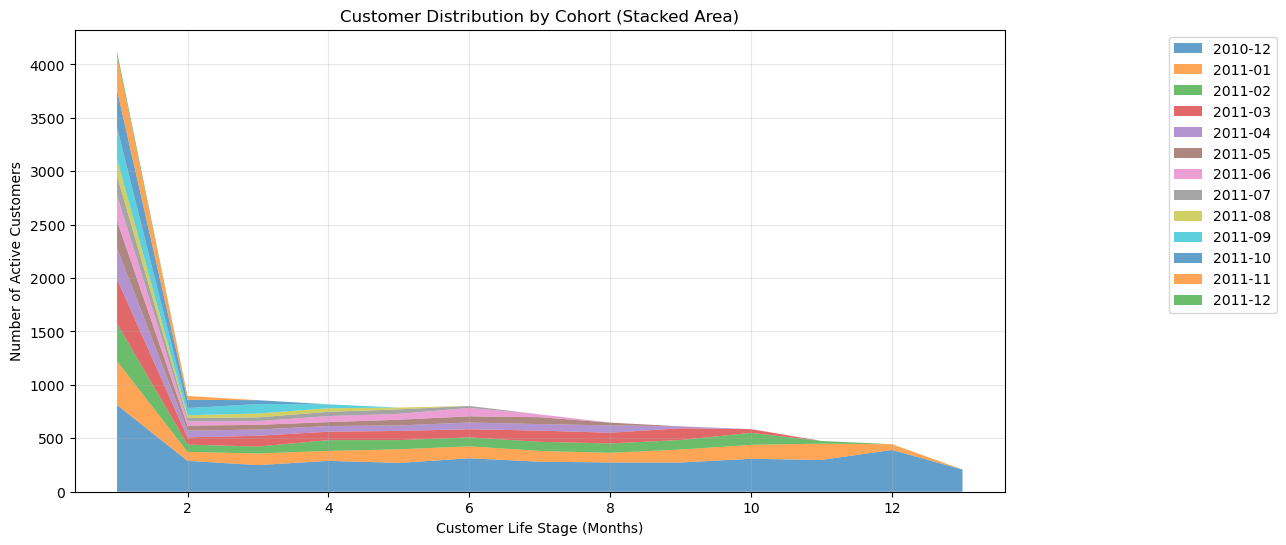

In [13]:
# D. Stacked Area Chart (Alternative Visualization):

# Prepare data for stacked area chart
stacked_data = cohort_counts.fillna(0)

plt.figure(figsize=(12, 6))
plt.stackplot(stacked_data.columns, 
              stacked_data.values, 
              labels=stacked_data.index.strftime('%Y-%m'),
              alpha=0.7)
plt.title('Customer Distribution by Cohort (Stacked Area)')
plt.xlabel('Customer Life Stage (Months)')
plt.ylabel('Number of Active Customers')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True, alpha=0.3)
plt.show()